In [101]:
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
# read csv
df = pd.read_csv('unfiltered_gwq.csv')
# include only state,< district, year
df = df[['state', 'district', 'year', 'chloride']]
# drop duplicates
df = df.drop_duplicates()
# drop rows with missing values
df = df.dropna()
# change indexing
df = df.reset_index(drop=True)
# save df as filtered_gwq.csv
df.to_csv('filtered_gwq.csv', index=False)

In [103]:
# for filtered_gwq.csv, change state Telangana to Andhra Pradesh if year < 2004
df = pd.read_csv('filtered_gwq.csv')
df.loc[(df['state'] == 'Telangana') & (df['year'] < 2004), 'state'] = 'Andhra Pradesh'
df.to_csv('filtered_gwq.csv', index=False)

/tmp/ipykernel_18497/3592663474.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('state').mean()


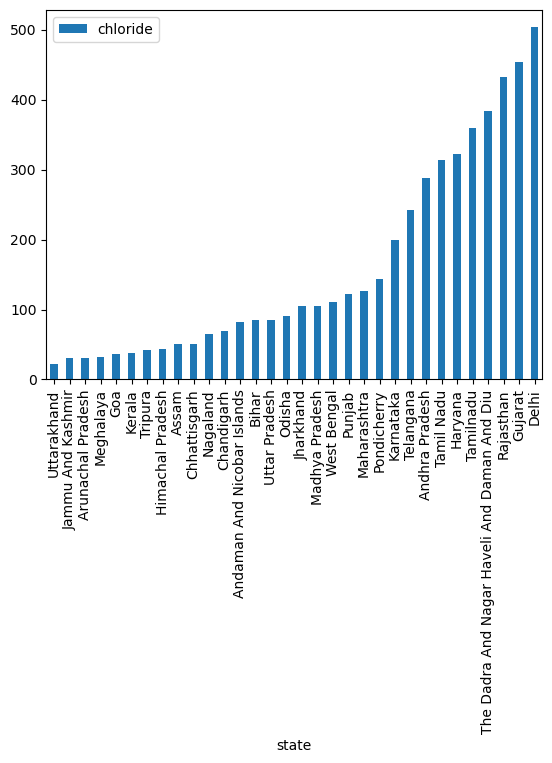

In [104]:
# read filtered_gwq.csv and draw histogram for state-wise avg chloride concentration
df = pd.read_csv('filtered_gwq.csv')
df = df.groupby('state').mean()
df = df.reset_index()
# print(df)

# sort by concentration
df = df.sort_values('chloride')
df.plot(x='state', y='chloride', kind='bar')
plt.show()

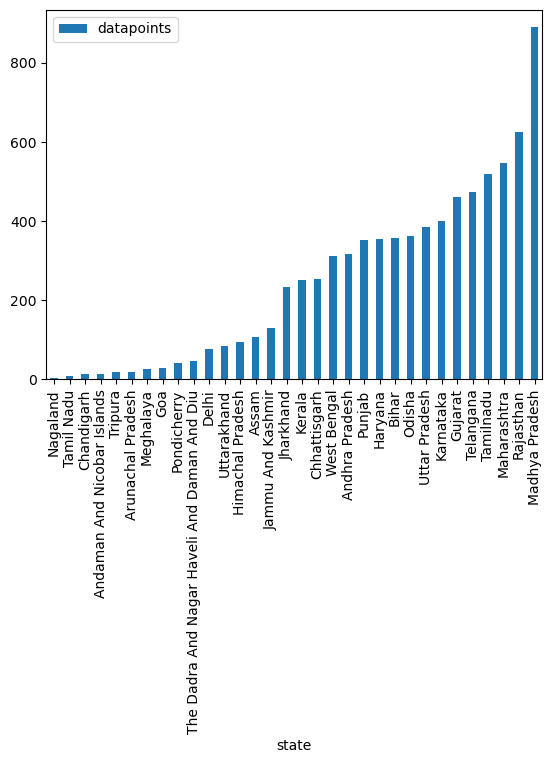

In [105]:
# print number of datapoints vs state
df = pd.read_csv('filtered_gwq.csv')
df = df.groupby('state').count()
df = df.reset_index()
df = df[['state', 'district']]
df.columns = ['state', 'datapoints']
df = df.sort_values('datapoints')
# print(df)
df.plot(x='state', y='datapoints', kind='bar')
plt.show()

                state missing expected  missing_ratio
3       Uttar Pradesh    1003     1387       0.723143
26            Tripura      57       76       0.750000
17              Assam     386      494       0.781377
28          Meghalaya     106      133       0.796992
23  Arunachal Pradesh      94      114       0.824561
27           Nagaland      16       19       0.842105
24         Tamil Nadu      87       95       0.915789


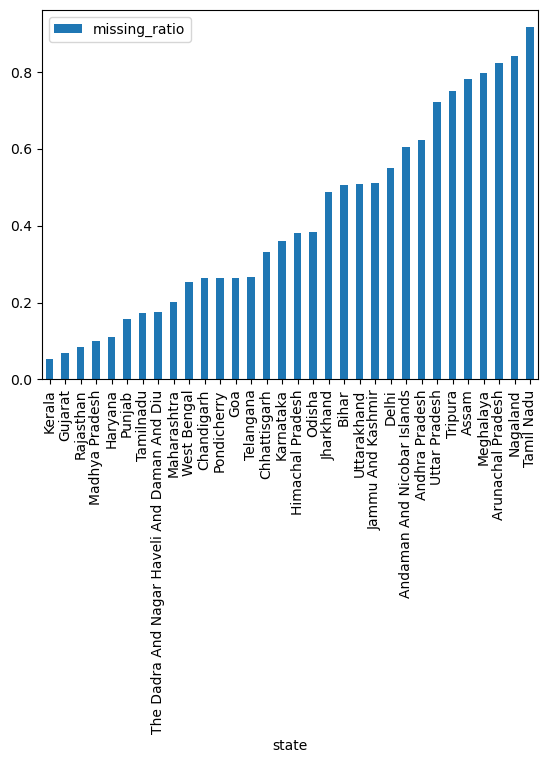

In [106]:
df = pd.read_csv('filtered_gwq.csv')
# Store names of all states
states = df['state'].unique()
# Create a new dataframe to store missing counts (integer)
incomplete_data = pd.DataFrame(columns=['state', 'missing', 'expected', 'missing_ratio'])
# Calculate missing data for each state
for state in states:
    districts = df[df['state'] == state]['district'].unique()
    available = df[df['state'] == state]
    missing_count = 19 * len(districts) - len(available)
    expected_count = 19 * len(districts)
    missing_ratio = 1 - (len(available) / expected_count)
    incomplete_data = pd.concat([incomplete_data, pd.DataFrame({'state': [state], 'missing': [missing_count], 'expected': [expected_count], 'missing_ratio': [missing_ratio]})], ignore_index=True)
incomplete_data = incomplete_data.sort_values('missing_ratio')
incomplete_data.plot(x='state', y='missing_ratio', kind='bar')
# Print states with missing ratio greater than 0.7
print(incomplete_data[incomplete_data['missing_ratio'] > 0.7])

In [144]:
df1 = pd.read_csv('unfiltered_sdp1.csv')
df2 = pd.read_csv('unfiltered_sdp2.csv')
df3 = pd.read_csv('unfiltered_sdp3.csv')
states = df1.keys()[1:]
df_sdp = pd.DataFrame(columns = df1.keys())
for state in states:
    df1_state = df1[state]
    df2_state = df2[state]
    df3_state = df3[state]
    # scaling factor 1 is df1_state's last value / df2_state's first value
    scaling_factor1 = df1_state.iloc[-1] / df2_state.iloc[0]
    # change df2_state values by scaling factor 1
    df2_state = df2_state * scaling_factor1
    # scaling factor 2 is df2_state's last value / df3_state's first value
    scaling_factor2 = df2_state.iloc[-1] / df3_state.iloc[0]
    # change df3_state values by scaling factor 2
    df3_state = df3_state * scaling_factor2
    # remove first and last elements of df2_state
    df2_state = df2_state[1:-1]
    df_sdp[state] = pd.concat([df1_state, df2_state, df3_state], ignore_index=True)
# df_sdp make years as 1999, 2000, and so on
df_sdp['YEAR'] = range(1999, 2019)
df_sdp.to_csv('filtered_sdp.csv', index=False)


In [165]:
# add sdp for every data in gwq
df_gwq = pd.read_csv('filtered_gwq.csv')
df_sdp = pd.read_csv('filtered_sdp.csv')
n_samples = 7808
# for every data in gwq, find the corresponding sdp value
for i in range(n_samples):
    state = df_gwq['state'][i]
    year = df_gwq['year'][i]
    state = state.upper()
    try:
        sdp = df_sdp[state][year - 1999]
        df_gwq.loc[i, 'sdp'] = sdp
    except:
        # print(state)
        # remove data
        df_gwq = df_gwq.drop(i)
# sort by state
df_gwq.dropna()
df_gwq = df_gwq.sort_values('state')
df_gwq.to_csv('filtered_gwq_sdp.csv', index=False)

In [166]:
# i indexes districts, t indexes years, and ui,t is random error.
# GWQi,t = β0 + β1SDPi,t + ui,t
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
y_mean = df_gwq['chloride'].mean()
# print(y_mean)
# calculate x_mean
x_mean = df_gwq['sdp'].mean()
# print(x_mean)
# calculate sum(xi-x_mean)(yi-y_mean) / sum(xi-x_mean)^2
beta1 = 0
beta2 = 0
n_samples = 7761
for i in range(n_samples):
    beta1 += (df_gwq['sdp'][i] - x_mean) * (df_gwq['chloride'][i] - y_mean)
    beta2 += (df_gwq['sdp'][i] - x_mean) ** 2
beta1 = beta1 / beta2
print(beta1)
# calculate beta0
beta0 = y_mean - beta1 * x_mean
print(beta0)
# summarize the results in a table and interpret
# print(df_gwq)
df_gwq['predicted_chloride'] = beta0 + beta1 * df_gwq['sdp']
df_gwq['error'] = df_gwq['chloride'] - df_gwq['predicted_chloride']
df_gwq.to_csv('filtered_gwq_sdp_predicted.csv', index=False)
# calculate R^2
ssr = 0
sst = 0
for i in range(n_samples):
    ssr += (df_gwq['predicted_chloride'][i] - y_mean) ** 2
    sst += (df_gwq['chloride'][i] - y_mean) ** 2
r_squared = ssr / sst
print(r_squared)

0.0001580769167029035
168.32199071447198
0.008510437117780748


In [ ]:
# plot graph for all states sdp vs year to verify sdp estimations from filtered_sdp.csv
df_sdp = pd.read_csv('filtered_sdp.csv')
states = df_sdp.keys()[1:]
# print(states)
for state in states:
    df_sdp.plot(x='YEAR', y=state)
    plt.show()

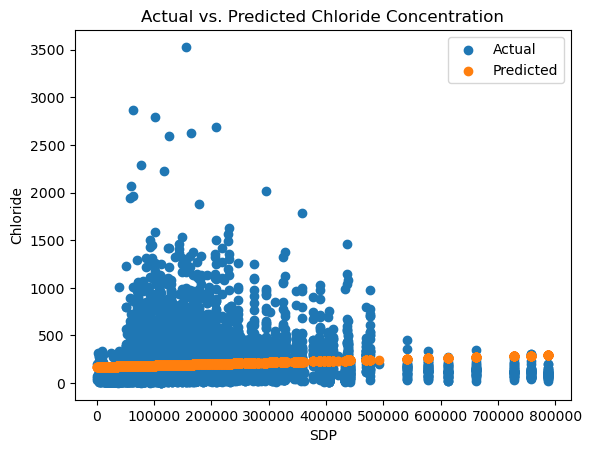

In [167]:
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted.csv')
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()

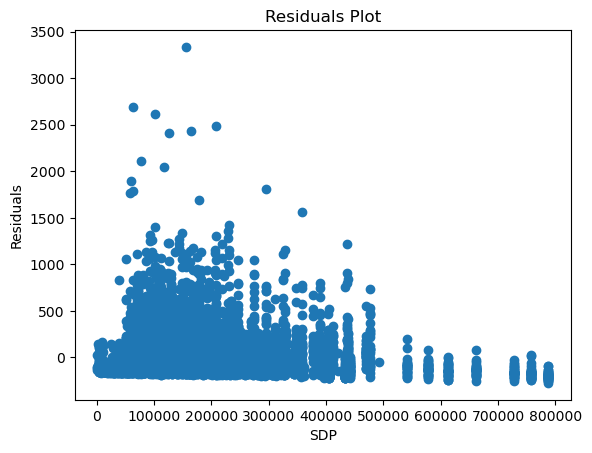

3335.2688651092603
-273.5835550896686


In [170]:
# Plot 2: Residuals (ûi,t) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['error'])
plt.xlabel('SDP')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

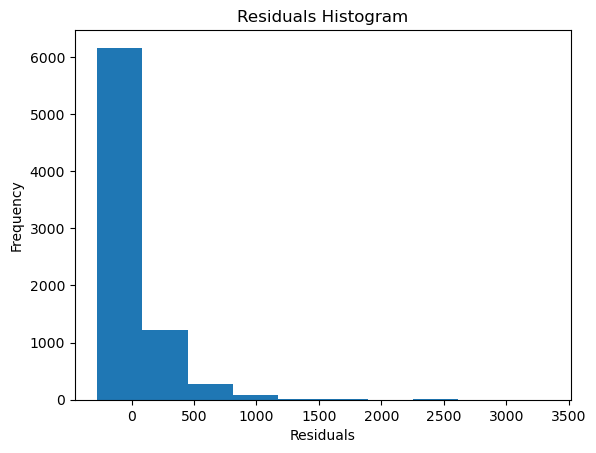

2.0372681319713593e-10


In [172]:
# Plot a histogram of ûi,t and verify that ∑û = 0.
plt.hist(df_gwq['error'])
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()
# verify that ∑û = 0
print(df_gwq['error'].sum())